<a href="https://colab.research.google.com/github/sonpn82/Tensor-flow-Developer-Certification-Exam/blob/main/04_Transfer_learning_in_tensorflow_part_1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU
!nvidia-smi

Fri Jul  1 00:21:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and become one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-01 00:21:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  84.5MB/s    in 1.9s    

2022-07-01 00:21:31 (84.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load our images in batches

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [6]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

>**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The log_dir parameter we've created above is only one option.

## Creating models using TensorFlow Hub

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our models'layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1  and  
https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [7]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub Url and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction Url.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # freeze the already learned paterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))  # from (224, 224) => (224, 224, 3)

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")                                   
  ])

  return model

### Create and testing Resnet TensorFlow Hub Feature Extraction Model

In [10]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220701-002147
Epoch 1/5
24/24 [==============================] - 32s 751ms/step - loss: 2.0460 - accuracy: 0.3320 - val_loss: 1.2714 - val_accuracy: 0.5964
Epoch 2/5
24/24 [==============================] - 16s 705ms/step - loss: 0.9474 - accuracy: 0.7240 - val_loss: 0.8768 - val_accuracy: 0.7332
Epoch 3/5
24/24 [==============================] - 16s 666ms/step - loss: 0.6314 - accuracy: 0.8227 - val_loss: 0.7588 - val_accuracy: 0.7668
Epoch 4/5
24/24 [==============================] - 16s 665ms/step - loss: 0.4908 - accuracy: 0.8813 - val_loss: 0.7229 - val_accuracy: 0.7660
Epoch 5/5
24/24 [==============================] - 16s 701ms/step - loss: 0.3858 - accuracy: 0.9120 - val_loss: 0.6829 - val_accuracy: 0.7840


Wow!

That is incredible. Our transfer learning feature extractor model outperformed All of previous models we built by hand... (substantially) and in a quicker training time and with only 10% of the training example!

In [14]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a funciton like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

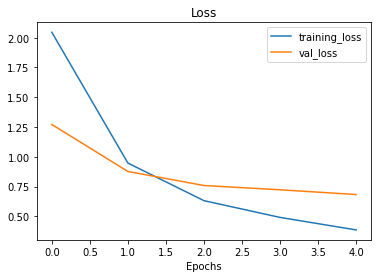

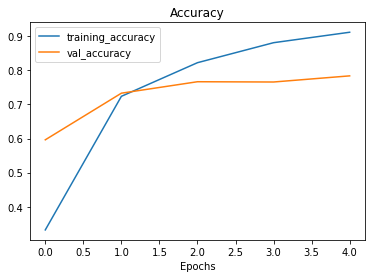

In [15]:
plot_loss_curves(resnet_history)

### Creating and testing efficientNetB0 TensorFlow Hub Feature Extraction model

In [16]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220701-002338
Epoch 1/5
24/24 [==============================] - 25s 708ms/step - loss: 1.8742 - accuracy: 0.3973 - val_loss: 1.3173 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 15s 641ms/step - loss: 1.0733 - accuracy: 0.7733 - val_loss: 0.8812 - val_accuracy: 0.8216
Epoch 3/5
24/24 [==============================] - 15s 642ms/step - loss: 0.7680 - accuracy: 0.8213 - val_loss: 0.7016 - val_accuracy: 0.8492
Epoch 4/5
24/24 [==============================] - 15s 635ms/step - loss: 0.6167 - accuracy: 0.8653 - val_loss: 0.6126 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 15s 633ms/step - loss: 0.5189 - accuracy: 0.8853 - val_loss: 0.5606 - val_accuracy: 0.8632


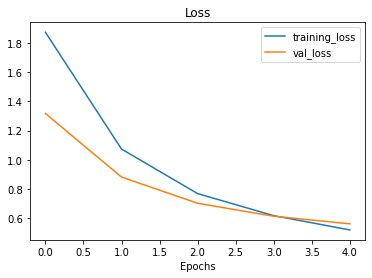

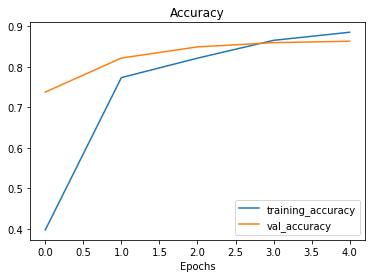

In [17]:
plot_loss_curves(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [20]:
# How many layers does our efficiencynetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes what so ever (ex using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (ex EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (Ex 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

>**Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [21]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. resnet50V2" \
  --description "Comparing two different TF Hub feature extraction model architecture using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=vbmuiyBaQJjEfLca5WO3ZSsDIRN99d&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically at https://tensorboard.dev/experiment/QwD5rSLZRGmXgS7Xl0v6CA/

In [22]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/C3mGmbT4RyCJgimS1xX6Ag/
	Name                 EfficientNetB0 vs. resnet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   C3mGmbT4RyCJgimS1xX6Ag
	Created              2022-07-01 00:26:18 (13 seconds ago)
	Updated              2022-07-01 00:26:20 (11 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794963
https://tensorboard.dev/experiment/n0LvAqCATv63QXpORevkSg/
	Name                 EfficientNetB0 vs. resnet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   n0LvAqCATv63QXpORevkSg
	Created              2022-06-30 23:55:45 (30 minutes ago)
	Updated              2022-06-30 23:55:47 (30 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor 

In [23]:
# Delete an experiment
# !tensorboard dev delete --experiment_id QwD5rSLZRGmXgS7Xl0v6CA

In [24]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/C3mGmbT4RyCJgimS1xX6Ag/
	Name                 EfficientNetB0 vs. resnet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   C3mGmbT4RyCJgimS1xX6Ag
	Created              2022-07-01 00:26:18 (29 seconds ago)
	Updated              2022-07-01 00:26:20 (27 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794963
https://tensorboard.dev/experiment/n0LvAqCATv63QXpORevkSg/
	Name                 EfficientNetB0 vs. resnet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   n0LvAqCATv63QXpORevkSg
	Created              2022-06-30 23:55:45 (31 minutes ago)
	Updated              2022-06-30 23:55:47 (31 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor 

## Exercises

Build and fit a model using MobileNetV2 architecture from TensorFlow Hub

In [25]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [26]:
# mobileNet model link
mobileNetUrl = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Create one keras layer for mobile net
feature_extractor_layer = hub.KerasLayer(mobileNetUrl,
                                         trainable=False,
                                         name="feature_extraction_layer",
                                         input_shape=IMG_SHAPE+(3,))

# Create the model
mobilenet_model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(train_data_10_percent.num_classes,
               activation="softmax",
               name="output_layer")                                       
])

# Compile the model
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# Fit the model
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="mobileNetV2")])

Saving TensorBoard log files to: tensorflow_hub/mobileNetV2/20220701-002650
Epoch 1/5
24/24 [==============================] - 19s 666ms/step - loss: 1.8821 - accuracy: 0.3613 - val_loss: 1.2428 - val_accuracy: 0.6324
Epoch 2/5
24/24 [==============================] - 15s 627ms/step - loss: 1.0108 - accuracy: 0.7107 - val_loss: 0.8575 - val_accuracy: 0.7516
Epoch 3/5
24/24 [==============================] - 15s 635ms/step - loss: 0.7101 - accuracy: 0.8160 - val_loss: 0.7394 - val_accuracy: 0.7752
Epoch 4/5
24/24 [==============================] - 15s 643ms/step - loss: 0.5712 - accuracy: 0.8613 - val_loss: 0.6633 - val_accuracy: 0.7976
Epoch 5/5
24/24 [==============================] - 15s 626ms/step - loss: 0.4773 - accuracy: 0.8920 - val_loss: 0.6272 - val_accuracy: 0.8040


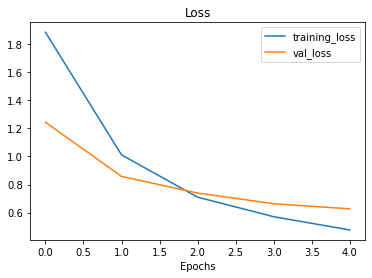

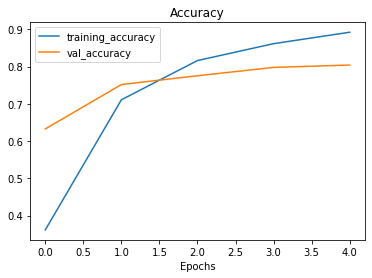

In [27]:
# Plot the loss curve
plot_loss_curves(mobilenet_history)

In [28]:
# Summary this model
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
# Upload tensorboard dev record
!tensorboard dev upload  --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. resnet50V2 vs mobileNetV2" \
  --description "Comparing three different TF Hub feature extraction model architecture using 10% of the training data" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/vjd99JNORSmJfwwEMqlJkA/

[2022-07-01T00:28:18] Started scanning logdir.
[2022-07-01T00:28:21] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.1 MB)
[2022-07-01T00:28:21] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/vjd99JNORSmJfwwEMqlJkA/
